# Homework #1: AB-testing and the Multi-Armed Bayesian Bandit 
# Written by: Xihe Yu

# Initialization of Priors
>First, I Suppose there are three i.i.d games called Red, Blue, and Other, with probilities of success 0.3, 0.5, and 0.7 respectively. 
>Then, due to no preference for any of these three games, each of them is set with the same prior distribution ( a beta distribution with $\alpha$=1 and $\beta$= 1), which is indeed also a uniform distribution.

In [1]:
import numpy as np; from scipy import stats; from scipy.stats import beta

# Specify true probability of success for each game
true_probs = {'Red': 0.3, 'Blue': 0.5, 'Other': 0.7}

# Specify uiniform priors for each choice
priors = {
    'Red': {'alpha': 1, 'beta': 1},
    'Blue': {'alpha': 1, 'beta': 1},
    'Other': {'alpha': 1, 'beta': 1}
}



# Thompson Sampling for Game Selection
> For each simulation iteration (representing a round of the game), I perform the following:
    
>    1. Sample from Posterior: For each game, I sample a value from its current Beta distribution. These values are drawn based on its current beliefs about the probability of success for each game (which initially are the priors).
    
>    2. Choose Game to Play: I select the game with the highest sampled value. This is because Thompson Sampling assumes that the sampled value is the true probability of success for that round, and by selecting the highest, i am choosing the game that is currently believed has the highest chance of success.







# Simultation and Updating the Posterior       
   
> I generate a random number between 0 and 1 and compare it to the true probability of success for the chosen game. If the random number is less than the true probability, I count it as a success; otherwise, it's a failure.

> After each game is played, the outcome (success or failure) is used to update the parameters of the Beta distribution for that game. 
This is done by incrementing $\alpha$ by 1 for each success or $\beta$ by 1 for each failure.

> I repeat previous steps for the specified number of simulations (1000 here). With each iteration, the posterior distributions become more informed by the accumulating evidence of successes and failures. Over time, the game with the higher true probability of success should be chosen more often, as the beliefs (posterior distributions) become more accurate.
- Note that the updating of the Beta distribution's parameters ($\alpha$ and $\beta$ )after each individual game (Bernoulli trial) reflects the sum of successes and failures up to that point, 
which is equivalent to what would be done if we were explicitly using a binomial distribution with 
n=1 for each trial. Thus, the Beta distribution in the code is being used to represent the binomially distributed outcome of each game, 
with its parameters being updated in a way that is consistent with the binomial likelihood function.
- Throughout this entire process, the distribution of the probability of success for each game becomes more and more peaked around its true value as more data is collected. The simulation leverages Bayesian updating to continually refine the understanding of the games' success probabilities based on the outcomes of the simulations.


In [26]:
# Set the seed
np.random.seed(365)

num_simulations = 1000

# Simulate the games and update the priors
results = {'Red': [], 'Blue': [], 'Other': []}
for i in range(num_simulations):
    # Sample from the posterior for each game using Thompson Sampling
    sampled_probs = {game: np.random.beta(priors[game]['alpha'], priors[game]['beta']) for game in true_probs}
    
    # Select the game with the highest sampled probability
    chosen_game = max(sampled_probs, key=sampled_probs.get)
    
    # Simulate playing the chosen game
    success = np.random.rand() < true_probs[chosen_game]
    
    # Update the results and priors based on the outcome
    results[chosen_game].append(success)
    priors[chosen_game]['alpha'] += success
    priors[chosen_game]['beta'] += (1 - success)

# Calculate the final posterior distributions
posterior_distributions = {
    game: beta(priors[game]['alpha'], priors[game]['beta'])
    for game in priors
}

# Summarize and visualize the results
for game, game_priors in priors.items():
    successes = sum(results[game])
    trials = len(results[game])
    mean_posterior = beta.mean(game_priors['alpha'], game_priors['beta'])
    ci_lower, ci_upper = beta.interval(0.95, game_priors['alpha'], game_priors['beta'])
    
    # Print summary
    print(f"{game.capitalize()} Game - Trials: {trials}, Successes: {successes}")
    print(f"Mean Posterior: {mean_posterior:.4f}, 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
    


Red Game - Trials: 3, Successes: 1
Mean Posterior: 0.3846, 95% CI: [0.2113, 0.5748]
Blue Game - Trials: 0, Successes: 0
Mean Posterior: 0.4091, 95% CI: [0.2701, 0.5559]
Other Game - Trials: 997, Successes: 677
Mean Posterior: 0.6812, 95% CI: [0.6715, 0.6908]


# Visualization of the Posterior:
>At the end of the simulations, the code plots the probability density functions of the Beta distributions for each game. This visualization shows the shape of the posterior distributions, providing a clear picture of our final beliefs about the probability of success for each game. The mean of these distributions and the 95% confidence intervals are also calculated and displayed, giving a quantitative summary of the posterior.


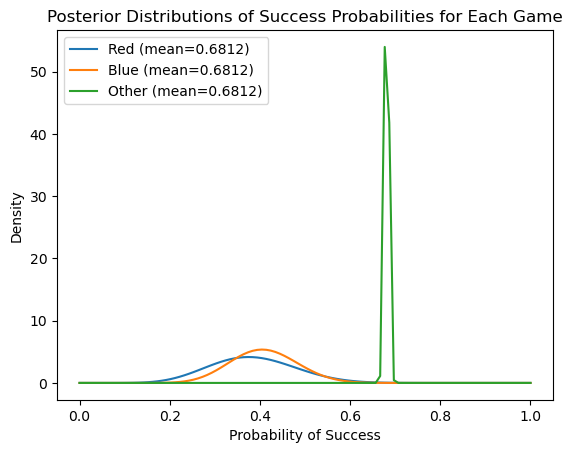

In [27]:
import matplotlib.pyplot as plt

for game, game_priors in priors.items():
# Plot the posterior distribution
    x = np.linspace(0, 1, 100)
    y = beta.pdf(x, game_priors['alpha'], game_priors['beta'])
    plt.plot(x, y, label=f"{game.capitalize()} (mean={mean_posterior:.4f})")

# Show the posterior distributions for all games
plt.title('Posterior Distributions of Success Probabilities for Each Game')
plt.xlabel('Probability of Success')
plt.ylabel('Density')
plt.legend()
plt.show()

# Conclusion
- According to previous outcome, there is strong preference for the "Other" game.was chosen 997 times out of 1000, which is a strong indication that the Thompson Sampling algorithm quickly identified it as the most promising option. With 677 successes out of 997 trials, the algorithm's preference for this option seems to be justified. The high mean posterior probability of 0.6812 and the narrow 95% confidence interval (CI) from 0.6715 to 0.6908 further reinforce that the "Other" game likely has a higher probability of success compared to the "Red" and "Blue" games.

- The outcome also provides evidence for limited exploration of "Red" and "Blue" games.The "Red" game was only tried 3 times, and the "Blue" game was not tried at all. This outcome suggests that the early trials of these games (especially for the "Blue" game) did not provide sufficient evidence to the algorithm to consider them as viable options compared to the "Other" game. It’s important to note that with such limited trials, our confidence in the performance of the "Red" and "Blue" games is low. Their mean posterior probabilities (0.3846 for "Red" and 0.4091 for "Blue") are based on very sparse data.

- In this simulation, Thompson Sampling quickly identified and exploited the "Other" game as the most promising option based on its success rate. However, the limited exploration of the "Red" and "Blue" games highlights a potential drawback of the algorithm in scenarios where initial outcomes may not accurately reflect true probabilities. This underscores the importance of balancing exploration and exploitation, particularly in environments where initial data may be misleading or not representative.